# Design of an Object Oriented Data Model

## 

1. **Field Type Classification** – Identify each field as primitive, optional, collection, or nested.
2. **Per-Field Effort Weights** – Assign LOC and complexity contributions for each category.
3. **Estimator Refactor** – Generalize estimators to accept a list of field types.
4. **Effort Aggregation** – Accumulate weighted LOC and complexity.

### Field Type Classification


In [326]:
from typing import Callable, Dict

# Individual estimators

def estimate_to_string_effort(num_fields: int) -> dict:
    loc = num_fields
    complexity = 1
    return {"loc": loc, "complexity": complexity}

def estimate_equals_effort(num_fields: int) -> dict:
    loc = num_fields + 1
    complexity = 2
    return {"loc": loc, "complexity": complexity}

def estimate_hash_code_effort(num_fields: int) -> dict:
    loc = num_fields + 1
    complexity = 2
    return {"loc": loc, "complexity": complexity}

def estimate_copy_with_effort(num_fields: int) -> dict:
    loc = num_fields + 2
    complexity = 3
    return {"loc": loc, "complexity": complexity}

def estimate_to_json_effort(num_fields: int) -> dict:
    loc = num_fields + 2
    complexity = 2
    return {"loc": loc, "complexity": complexity}

def estimate_from_json_effort(num_fields: int) -> dict:
    loc = num_fields + 2
    complexity = 3
    return {"loc": loc, "complexity": complexity}

def estimate_constructor_effort(num_fields: int) -> dict:
    loc = num_fields + 1
    complexity = 1
    return {"loc": loc, "complexity": complexity}


# Registry of estimators
effort_estimators: Dict[str, Callable[[int], dict]] = {
    "toString": estimate_to_string_effort,
    "equals": estimate_equals_effort,
    "hashCode": estimate_hash_code_effort,
    "copyWith": estimate_copy_with_effort,
    "toJson": estimate_to_json_effort,
    "fromJson": estimate_from_json_effort,
    "constructor": estimate_constructor_effort,
}



In [327]:
def classify_field_type(type_str: str) -> str:
    """
    Classify a type string into one of: primitive, optional, collection, nested.
    """
    primitive_types = {"int", "double", "bool", "String", "number"}
    
    if type_str.endswith("?"):
        return "optional"
    elif type_str in primitive_types:
        return "primitive"
    elif type_str.startswith("List") or type_str.startswith("Map"):
        return "collection"
    else:
        return "nested"


### Complexity Weights

In [328]:
FIELD_COMPLEXITY_WEIGHTS = {
    "primitive": {"loc": 1, "complexity": 1},
    "optional": {"loc": 1, "complexity": 2},
    "collection": {"loc": 2, "complexity": 3},
    "nested": {"loc": 2, "complexity": 4},
}


### Generalized Estimator Utility

We define a helper to compute weighted totals across field types:


In [329]:
from typing import List

def compute_weighted_effort(field_types: List[str], base_loc=0, base_complexity=0, scaling=1.0) -> dict:
    """
    Aggregate LOC and complexity for a list of field types, with optional base values.
    """
    total_loc = base_loc
    total_complexity = base_complexity

    for t in field_types:
        category = classify_field_type(t)
        weights = FIELD_COMPLEXITY_WEIGHTS[category]
        total_loc += scaling * weights["loc"]
        total_complexity += scaling * weights["complexity"]

    return {
        "loc": int(round(total_loc)),
        "complexity": int(round(total_complexity)),
    }


### Estimators



In [330]:

def estimate_to_string_effort_typed(field_types: List[str]) -> dict:
    return compute_weighted_effort(field_types, base_loc=0, base_complexity=1)

def estimate_equals_effort_typed(field_types: List[str]) -> dict:
    return compute_weighted_effort(field_types, base_loc=1, base_complexity=1)

def estimate_copy_with_effort_typed(field_types: List[str]) -> dict:
    return compute_weighted_effort(field_types, base_loc=2, base_complexity=2)

def estimate_validation_class_effort_typed(field_types: List[str]) -> dict:
    return compute_weighted_effort(field_types, base_loc=3, base_complexity=2, scaling=2)

def estimate_transformer_class_effort_typed(field_types: List[str]) -> dict:
    return compute_weighted_effort(field_types, scaling=2)



In [331]:
### Registry

In [332]:
typed_effort_estimators = {
    "toString": estimate_to_string_effort_typed,
    "equals": estimate_equals_effort_typed,
    "copyWith": estimate_copy_with_effort_typed,
    "validationClass": estimate_validation_class_effort_typed,
    "transformerClass": estimate_transformer_class_effort_typed,
    # more as needed...
}


### Effort Summary Function

In [333]:
def estimate_total_effort_typed(field_types: List[str], selected_functions=None) -> dict:
    if selected_functions is None:
        selected_functions = list(typed_effort_estimators.keys())

    breakdown = {}
    total_loc = 0
    total_complexity = 0

    for name in selected_functions:
        estimator = typed_effort_estimators.get(name)
        if estimator:
            result = estimator(field_types)
            breakdown[name] = result
            total_loc += result["loc"]
            total_complexity += result["complexity"]

    return {
        "total_loc": total_loc,
        "total_complexity": total_complexity,
        "breakdown": breakdown
    }



### Example Usage

In [334]:

field_types = ["int", "String", "List<int>", "Map<String, dynamic>", "User", "bool?"]
report = estimate_total_effort_typed(field_types)
report


{'total_loc': 69,
 'total_complexity': 104,
 'breakdown': {'toString': {'loc': 9, 'complexity': 15},
  'equals': {'loc': 10, 'complexity': 15},
  'copyWith': {'loc': 11, 'complexity': 16},
  'validationClass': {'loc': 21, 'complexity': 30},
  'transformerClass': {'loc': 18, 'complexity': 28}}}

In [335]:
from typing import Union

def estimate_total_effort(
    fields: Union[int, List[str]],
    selected_functions: List[str] = None
) -> dict:
    """
    Unified interface for estimating total implementation effort.

    Parameters:
    - fields: Either an integer (number of fields) or a list of field type strings.
    - selected_functions: Optional list of utility names to include.

    Returns:
    - Dictionary with total LOC, total complexity, and per-function breakdown.
    """
    if isinstance(fields, int):
        # Use untyped estimators
        estimators = effort_estimators
        get_estimate = lambda fn: estimators[fn](fields)
    elif isinstance(fields, list):
        # Use typed estimators
        estimators = typed_effort_estimators
        get_estimate = lambda fn: estimators[fn](fields)
    else:
        raise ValueError("`fields` must be either an integer or a list of type strings.")

    if selected_functions is None:
        selected_functions = list(estimators.keys())

    breakdown = {}
    total_loc = 0
    total_complexity = 0

    for fn in selected_functions:
        if fn in estimators:
            result = get_estimate(fn)
            breakdown[fn] = result
            total_loc += result["loc"]
            total_complexity += result["complexity"]

    return {
        "total_loc": total_loc,
        "total_complexity": total_complexity,
        "breakdown": breakdown
    }


Untyped: using just the field count


In [336]:
estimate_total_effort(fields=5)

{'total_loc': 44,
 'total_complexity': 14,
 'breakdown': {'toString': {'loc': 5, 'complexity': 1},
  'equals': {'loc': 6, 'complexity': 2},
  'hashCode': {'loc': 6, 'complexity': 2},
  'copyWith': {'loc': 7, 'complexity': 3},
  'toJson': {'loc': 7, 'complexity': 2},
  'fromJson': {'loc': 7, 'complexity': 3},
  'constructor': {'loc': 6, 'complexity': 1}}}

Typed: using list of field types


In [337]:
field_types = ["int", "String", "List<int>", "User", "bool?"]
estimate_total_effort(fields=field_types)

{'total_loc': 55,
 'total_complexity': 83,
 'breakdown': {'toString': {'loc': 7, 'complexity': 12},
  'equals': {'loc': 8, 'complexity': 12},
  'copyWith': {'loc': 9, 'complexity': 13},
  'validationClass': {'loc': 17, 'complexity': 24},
  'transformerClass': {'loc': 14, 'complexity': 22}}}

### A - Flat Model

All fields live in a single "mega" concept (class) — say, 100 primitive fields

In [338]:
def build_flat_model(num_fields: int) -> dict:
    """
    Construct a flat model where all fields are primitive.
    
    Returns:
        Dictionary representing a single concept with all fields.
    """
    field_types = ["int"] * num_fields
    return {
        "FlatConcept": field_types
    }


### B - Modular Model

Those same fields are distributed across child concepts, and the parent concept holds references to those. 

In [339]:
def build_modular_model(total_fields: int, fields_per_child: int) -> dict:
    """
    Constructs a modular model:
    - Divides fields into child concepts.
    - A parent concept holds references to the child concepts.

    Returns:
        Dictionary mapping concept names to their list of field types.
    """
    if total_fields % fields_per_child != 0:
        raise ValueError("total_fields must be divisible by fields_per_child.")

    num_children = total_fields // fields_per_child
    model = {}

    # Create child concepts
    for i in range(num_children):
        concept_name = f"ChildConcept{i + 1}"
        model[concept_name] = ["int"] * fields_per_child

    # Create parent concept with references to all child concepts
    parent_fields = list(model.keys())  # Treat each child as a field (reference)
    model["ParentConcept"] = parent_fields  # These are nested references

    return model

### Estimation per Model

In [340]:
def estimate_model_effort(model: dict, selected_functions: List[str] = None) -> dict:
    """
    Estimate total effort for a model with optional function filtering.
    """
    total_loc = 0
    total_complexity = 0
    concept_breakdown = {}

    for concept_name, field_types in model.items():
        result = estimate_total_effort(fields=field_types, selected_functions=selected_functions)
        concept_breakdown[concept_name] = result
        total_loc += result["total_loc"]
        total_complexity += result["total_complexity"]

    return {
        "total_loc": total_loc,
        "total_complexity": total_complexity,
        "concept_breakdown": concept_breakdown
    }


# Comparison Framework

In [341]:
def compare_flat_vs_modular(
    total_fields: int,
    fields_per_child: int,
    selected_functions: List[str] = None
) -> dict:
    """
    Run A/B test between flat and modular models using selected utilities.
    """
    flat_model = build_flat_model(total_fields)
    modular_model = build_modular_model(total_fields, fields_per_child)

    flat_effort = estimate_model_effort(flat_model, selected_functions)
    modular_effort = estimate_model_effort(modular_model, selected_functions)

    return {
        "flat_model": flat_effort,
        "modular_model": modular_effort,
        "delta": {
            "loc": modular_effort["total_loc"] - flat_effort["total_loc"],
            "complexity": modular_effort["total_complexity"] - flat_effort["total_complexity"]
        }
    }


Example:

In [342]:
result = compare_flat_vs_modular(100, 10, selected_functions=["toString", "equals"])
result

{'flat_model': {'total_loc': 201,
  'total_complexity': 202,
  'concept_breakdown': {'FlatConcept': {'total_loc': 201,
    'total_complexity': 202,
    'breakdown': {'toString': {'loc': 100, 'complexity': 101},
     'equals': {'loc': 101, 'complexity': 101}}}}},
 'modular_model': {'total_loc': 251,
  'total_complexity': 302,
  'concept_breakdown': {'ChildConcept1': {'total_loc': 21,
    'total_complexity': 22,
    'breakdown': {'toString': {'loc': 10, 'complexity': 11},
     'equals': {'loc': 11, 'complexity': 11}}},
   'ChildConcept2': {'total_loc': 21,
    'total_complexity': 22,
    'breakdown': {'toString': {'loc': 10, 'complexity': 11},
     'equals': {'loc': 11, 'complexity': 11}}},
   'ChildConcept3': {'total_loc': 21,
    'total_complexity': 22,
    'breakdown': {'toString': {'loc': 10, 'complexity': 11},
     'equals': {'loc': 11, 'complexity': 11}}},
   'ChildConcept4': {'total_loc': 21,
    'total_complexity': 22,
    'breakdown': {'toString': {'loc': 10, 'complexity': 11},


### Simulation

We'll define a function that runs compare_flat_vs_modular() across combinations of total_fields and fields_per_child, and stores the results.

In [343]:
import pandas as pd

def run_modularity_experiments(
    total_field_values: List[int],
    fields_per_child_values: List[int],
    selected_functions: List[str] = None
) -> pd.DataFrame:
    """
    Runs modularity experiments across ranges of total_fields and fields_per_child.

    Returns:
        A pandas DataFrame with results per configuration.
    """
    results = []

    for total_fields in total_field_values:
        for fields_per_child in fields_per_child_values:
            if total_fields % fields_per_child != 0:
                continue  # skip incompatible combinations

            comparison = compare_flat_vs_modular(
                total_fields=total_fields,
                fields_per_child=fields_per_child,
                selected_functions=selected_functions
            )

            results.append({
                "total_fields": total_fields,
                "fields_per_child": fields_per_child,
                "num_children": total_fields // fields_per_child,
                "flat_loc": comparison["flat_model"]["total_loc"],
                "modular_loc": comparison["modular_model"]["total_loc"],
                "delta_loc": comparison["delta"]["loc"],
                "flat_complexity": comparison["flat_model"]["total_complexity"],
                "modular_complexity": comparison["modular_model"]["total_complexity"],
                "delta_complexity": comparison["delta"]["complexity"]
            })

    return pd.DataFrame(results)


In [344]:
# Define ranges
total_fields_range = [50, 100, 150]
fields_per_child_range = [5, 10, 15, 25]

# Run experiments for toString + equals + copyWith
df_results = run_modularity_experiments(
    total_field_values=total_fields_range,
    fields_per_child_values=fields_per_child_range,
    selected_functions=["toString", "equals", "copyWith"]
)

summary = df_results[["delta_loc", "delta_complexity"]].describe()
summary

,delta_loc,delta_complexity
count,10.000000,10.000000
mean,100.800000,179.200000
std,76.579371,136.141103
min,18.000000,32.000000
25%,47.250000,84.000000
50%,90.000000,160.000000
75%,123.750000,220.000000
max,270.000000,480.000000


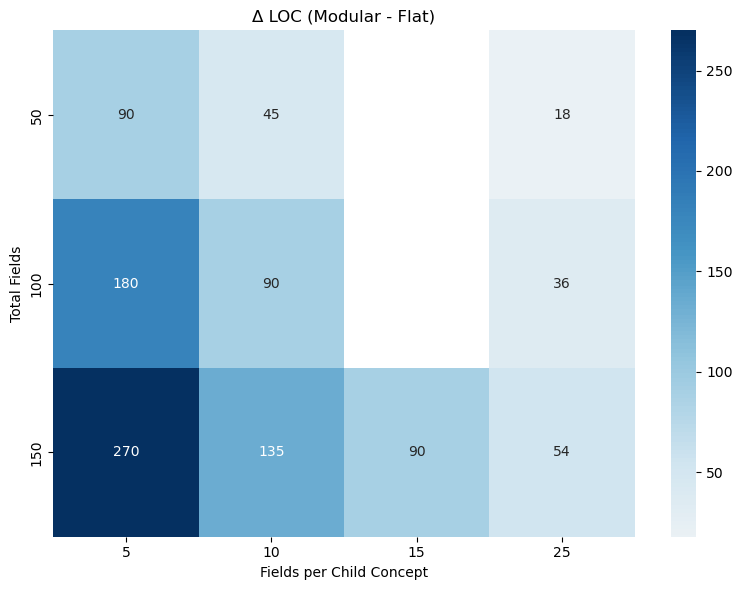

In [345]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of delta LOC
pivot_loc = df_results.pivot(
    index="total_fields", columns="fields_per_child", values="delta_loc"
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_loc, annot=True, fmt=".0f", cmap="RdBu", center=0)
plt.title("Δ LOC (Modular - Flat)")
plt.xlabel("Fields per Child Concept")
plt.ylabel("Total Fields")
plt.tight_layout()
plt.show()



***Interpretation Highlights***

- **Monotonic Trend**: As `fields_per_child` increases (fewer, larger children), the overhead (`Δ LOC`) **decreases**.
- **Linear Scaling**: For fixed `fields_per_child`, increasing `total_fields` leads to **linear growth** in `Δ LOC`. This confirms that modularity overhead scales proportionally with the number of partitions.
- **Minimum Overhead**: The lowest `Δ LOC` is observed when `fields_per_child` is large (i.e., fewer child concepts, more fields per child).



## Ratio of modular effort (B) to flat effort (A)

Let's create a line chart that compares the ratio of modular effort (B) to flat effort (A) for both LOC and complexity, for a fixed total_fields = 150, and with a separate line for each fields_per_child value.

In [346]:
import matplotlib.pyplot as plt

def plot_effort_ratios_for_fixed_total_fields(
    total_fields: int,
    fields_per_child_values: List[int],
    selected_functions: List[str] = None
):
    ratio_data = []

    for fpc in fields_per_child_values:
        if total_fields % fpc != 0:
            continue

        result = compare_flat_vs_modular(
            total_fields=total_fields,
            fields_per_child=fpc,
            selected_functions=selected_functions
        )

        flat_loc = result["flat_model"]["total_loc"]
        flat_complexity = result["flat_model"]["total_complexity"]
        modular_loc = result["modular_model"]["total_loc"]
        modular_complexity = result["modular_model"]["total_complexity"]

        ratio_data.append({
            "fields_per_child": fpc,
            "loc_ratio": modular_loc / flat_loc,
            "complexity_ratio": modular_complexity / flat_complexity
        })

    # Convert to DataFrame for plotting
    df = pd.DataFrame(ratio_data).sort_values("fields_per_child")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df["fields_per_child"], df["loc_ratio"], marker='o', label='LOC Ratio (Modular / Flat)')
    plt.plot(df["fields_per_child"], df["complexity_ratio"], marker='s', label='Complexity Ratio (Modular / Flat)')
    plt.axhline(1.0, linestyle="--", color="gray", linewidth=1)

    plt.title(f"Effort Ratio (Modular / Flat) — Total Fields = {total_fields}")
    plt.xlabel("Fields per Child Concept")
    plt.ylabel("Ratio")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


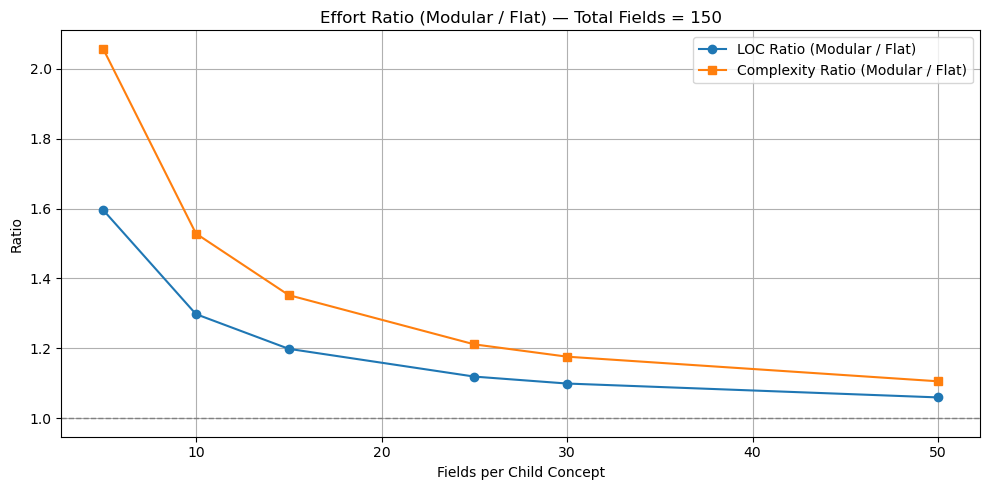

In [347]:
plot_effort_ratios_for_fixed_total_fields(
    total_fields=150,
    fields_per_child_values=[5, 10, 15, 25, 30, 50],
    selected_functions=["toString", "equals", "copyWith"]
)

### 🟠 **Complexity Ratio (Modular / Flat)**

- **Starts at ~2.1** for `fields_per_child = 5`:  
  This is a **very steep cost**, more than doubling the cognitive or branching complexity. Each small child concept adds repeated structural and logic overhead.
  
- **Drops quickly to ~1.2** by `fields_per_child = 25`, and flattens near **1.1** at 50:  
  This shows that **modularity becomes much less expensive in terms of complexity** when child concepts group more fields.

- **Interpretation**:  
  Modularity creates a *fixed complexity overhead per concept*. As you increase `fields_per_child`, this fixed cost is shared among more fields, so **relative complexity drops**.


### 🔵 **LOC Ratio (Modular / Flat)**

- **Starts at ~1.6** and gradually falls toward **1.05–1.1** by `fields_per_child = 50`:  
  Even at the most modular extreme, you're only adding ~60% more LOC — much less painful than the complexity hit.

- **LOC curve is smoother and less steep** than complexity:  
  This suggests that **code duplication and boilerplate** scale linearly with the number of concepts, but don’t explode like branching logic.

### Key Takeaways

- **Excessive modularity (many small concepts)** has a **very high complexity cost** and a **moderate LOC cost**.
- **Moderate modularity (larger concepts)** brings the modular/flat ratios **close to 1.0**, especially for LOC.
